In [1]:
import sys
import os
from glob import glob
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask
import numpy as np
sys.path.append("..")
from src.processing import _crop_image, _image_processing, _write_image, _output_params
from src.utils import _input_generator, _output_date

In [ ]:
# Finding all subdirectories and loading files
shp_dirs = os.listdir("././Gijon2/aois/subasset_location_shp")
shp_dirs_selected = [d for d in shp_dirs if d != "Gijon_Perimeter"]
sen2_dirs = os.listdir("./Gijon2/Sentinel2")
sen2_dirs_selected = [d for d in sen2_dirs if d not in
                      ["L1C", "L2A", "Cloud_Images"]\
                      and d != "Cloud_report_Gijon.csv"]
nhi_swir_files = glob("./Gijon2/Sentinel2/NHI_SWIR/*.tif")
raw_cloud_files = glob("./Gijon2/Sentinel2/Cloud_Images/*.tif")

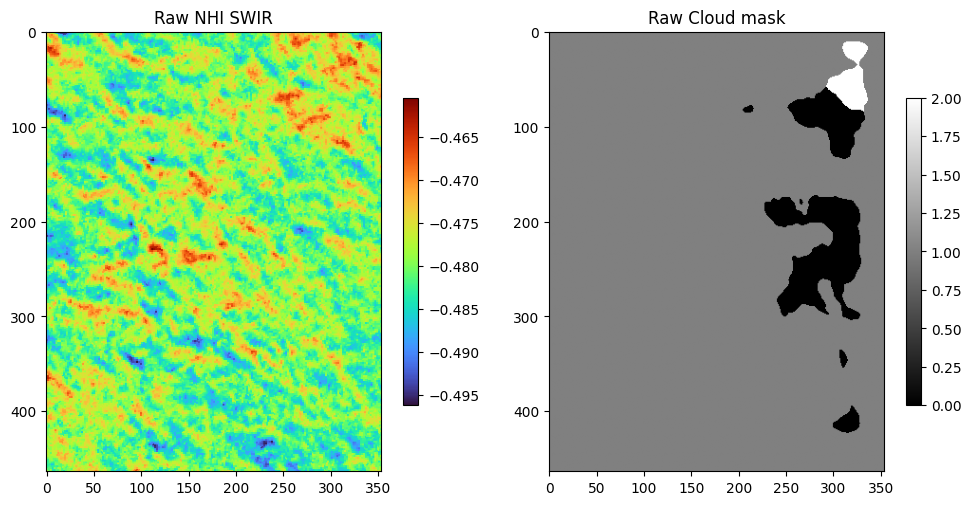

In [3]:
# Reading and plotting one image
with rio.open(nhi_swir_files[0]) as img:
    arr1 = img.read(1)

with rio.open(raw_cloud_files[0]) as img:
    arr2 = img.read(1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
img1 = ax[0].imshow(arr1, cmap="turbo")
plt.colorbar(img1, ax=ax[0], shrink=0.7)
ax[0].set_title("Raw NHI SWIR")
img2 = ax[1].imshow(arr2, cmap="grey")
plt.colorbar(img2, ax=ax[1], shrink=0.7)
ax[1].set_title("Raw Cloud mask")
plt.tight_layout()
plt.show()

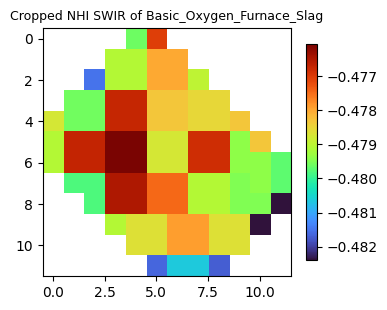

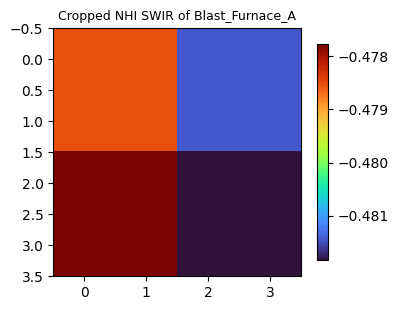

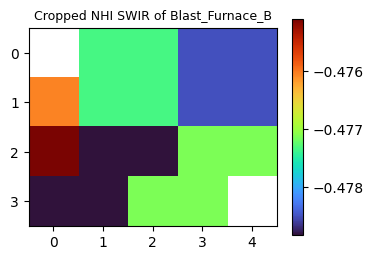

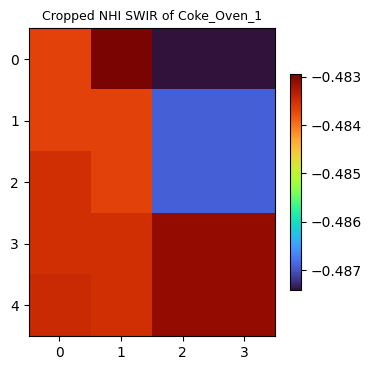

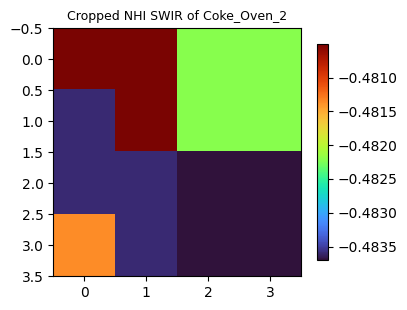

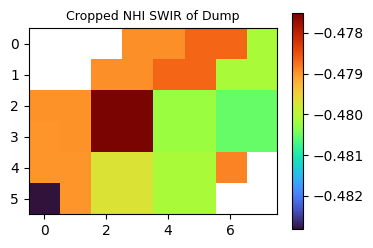

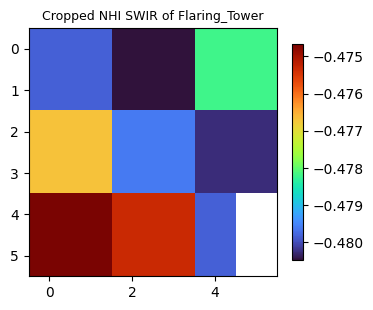

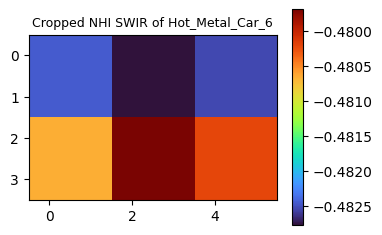

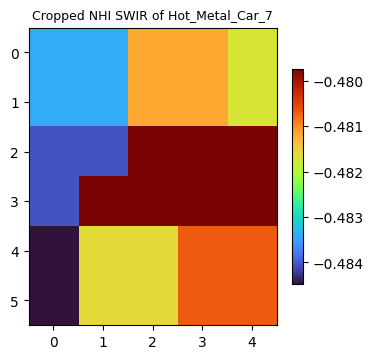

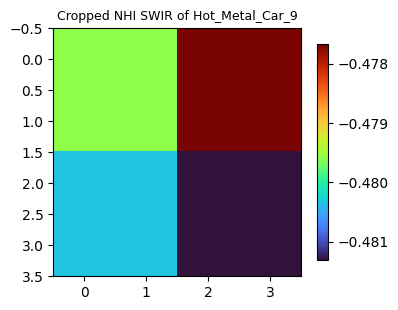

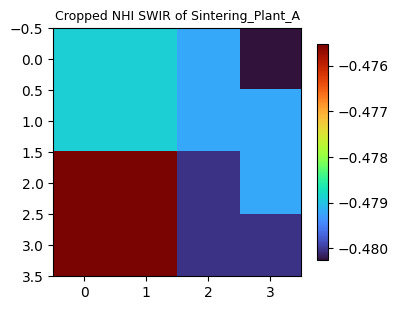

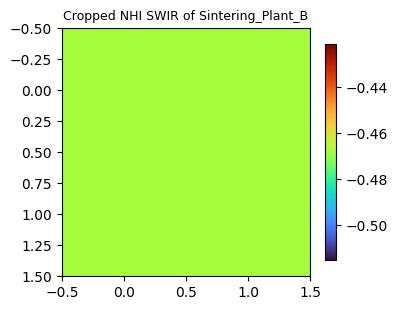

In [4]:
# cropping images using vector data and plotting cropped image
for d in shp_dirs_selected:
    vec = gpd.read_file(f"./Gijon2/aois/subasset_location_shp/{d}/{d}.shp")
    with rio.open(nhi_swir_files[0]) as img:
        vec = vec.to_crs(img.crs)
        crp_img, crp_trans = mask(img, vec.geometry, crop=True)

    fig, ax = plt.subplots(figsize=(4, 4))
    img3 = plt.imshow(crp_img.squeeze(), cmap="turbo")
    plt.colorbar(img3, shrink=0.7)
    ax.set_title(f"Cropped NHI SWIR of {d}", fontsize=9)
    plt.show()

In [ ]:
# Cropping all satellite files using location shapes and saving cropped images to new directory.

for file, location in _input_generator(shp_dirs_selected, sen2_dirs_selected):
    date, varname = _output_date(
        file
    )
    img, meta = _crop_image(
        input_path=file,
        shapefile_path=f"./Gijon2/aois/subasset_location_shp/{location}/{location}.shp"
    )
    _write_image(
        img=img,
        metadata=meta,
        date=date,
        location=location,
        varname=varname,
        output_path="Cropped_Images/Features_new"
    )

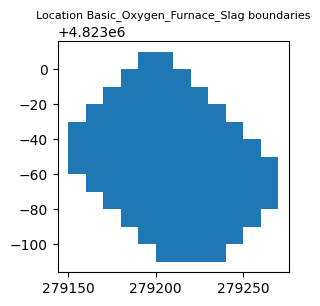

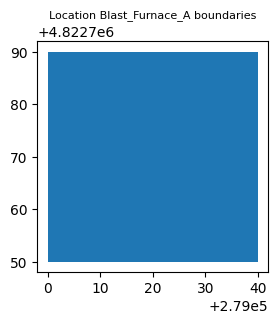

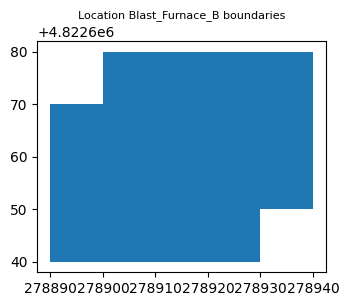

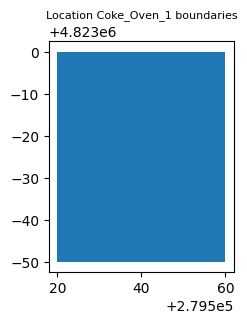

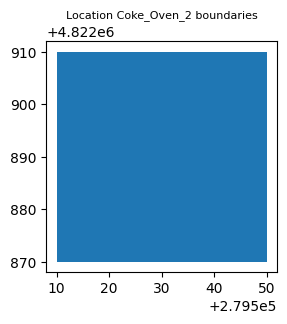

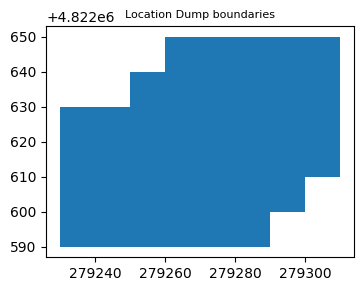

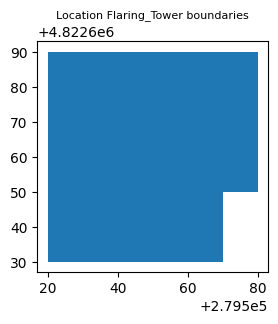

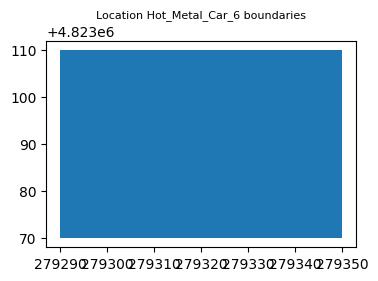

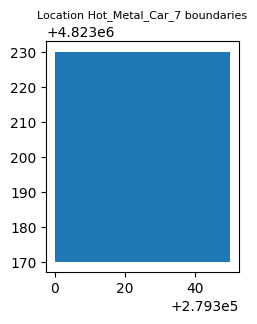

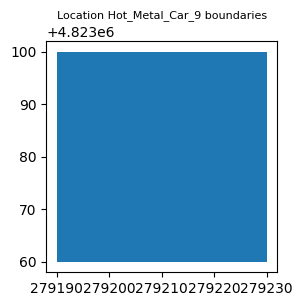

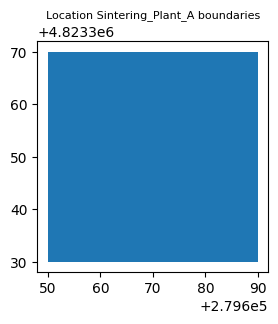

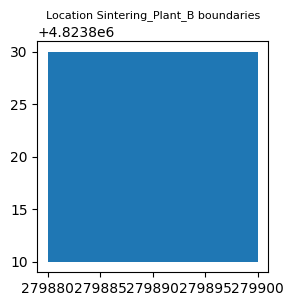

In [ ]:
# Plotting shape files of all locations.
for d in shp_dirs_selected:
    vec = gpd.read_file(f"./Gijon2/aois/subasset_location_shp/{d}/{d}.shp")
    vec.geometry.plot(figsize=(4,3))
    plt.title(f"Location {d} boundaries", fontsize=8)
    plt.show()

In [ ]:
# Removing cloudy pixels in the cropped images using cloud files. Saving cloud-free images to a new directory.
for loc in shp_dirs_selected:
    cloud_files = sorted(glob(f"./Cropped_Images/Cloud_Images/{loc}/*.tif"))
    for feat in sen2_dirs_selected:
        feature_files = sorted(glob(f"./Cropped_Images/Features/{loc}/{feat}/*.tif"))
        for i, j in zip(cloud_files, feature_files):
            date, _ = _output_params(j)
            clean_image, metadata = _image_processing(
                i,
                j,
                cloud_free=False
            )
            _write_image(
                img=clean_image,
                metadata=metadata,
                date=date,
                location=loc,
                varname=feat,
                output_path="Cropped_Images/CloudFree_Features2"
    )